In [1]:
%%capture
%run naive_algorithm.ipynb
%run features_engineering.ipynb

In [2]:
import random 
import seaborn as sns
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

import xgboost as xgb
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


from sklearn.preprocessing import StandardScaler,MinMaxScaler

import shap

## Split Train/Test

Probleme de segments dans lequel sont compris d'autres segments , pour eviter de la fuite de données dans le cas ou
segment se retrouverais dans le train et une partie de celui ci dans le train : 

* Calcul de jour calendaire/année de chaque segment
* Selection au hasard de certaines dates qui constitueront le test_set , tout le reste dans le train_set
* De cette maniere aucun segment réalisé a une meme date ne pourra se retrouver a la fois dans le train et le test


In [3]:
segments_df.head(5)

,id,activity_id,athlete_id,name,elapsed_time,moving_time,distance,average_cadence,average_watts,average_grade,...,climb_category,average_heart_rate,max_heart_rate,start_time,start_date,time_activities_last_30d,type_virtualride,days_since_last_activity,average_climbcat_last_30d,average_speed_last_30d
0,18389384,4878366984,10944546,Zwift Worlds KOM Reverse,1759,1759,5733.9,76.2,208.1,6.9,...,3,171.8,185.0,17:50:01,2021-03-02,357.10,1,8,0.06,7.87
1,18397927,4878366984,10944546,Innsbruck KOM Reverse,1759,1759,5734.4,76.2,208.1,6.9,...,3,171.8,185.0,17:50:01,2021-03-02,357.10,1,8,0.06,7.87
2,27180310,4878366984,10944546,Innsbruck KOM Up and Down Reverse,2235,2235,13163.1,74.5,182.8,-0.1,...,0,166.5,187.0,17:50:01,2021-03-02,357.10,1,8,0.06,7.87
3,27180273,4878366984,10944546,Innsbruck KOM Forward Descent,476,476,7433.2,68.4,89.3,-5.6,...,0,147.2,187.0,18:19:20,2021-03-02,357.10,1,8,0.06,7.87
4,24674235,4831255939,10944546,Champs-Élysées,653,653,6623.1,82.3,202.8,0.0,...,0,161.2,170.0,18:46:25,2021-02-22,315.25,1,0,0.06,7.76


In [4]:
calendar_days = []
for date in segments_df['start_date']:
    calendar_day = date.strftime('%j%Y')
    calendar_days.append(calendar_day)

segments_df['calendar_day'] = calendar_days

In [5]:
dates = segments_df['calendar_day'].unique()

In [6]:
dates = dates.tolist()

In [7]:
dates

['0612021',
 '0532021',
 '0512021',
 '0482021',
 '0432021',
 '0402021',
 '0372021',
 '0312021',
 '0212021',
 '0172021',
 '3592020',
 '3502020',
 '3362020',
 '3332020',
 '3202020',
 '3182020',
 '3172020',
 '3162020',
 '3062020',
 '3042020',
 '3022020',
 '3002020',
 '2992020',
 '2982020',
 '2962020',
 '2922020',
 '2912020',
 '2902020',
 '2872020',
 '2862020',
 '2852020',
 '2842020',
 '2832020',
 '2812020',
 '2802020',
 '2782020',
 '2772020',
 '2762020',
 '2752020',
 '2732020',
 '2722020',
 '2712020',
 '2702020',
 '2682020',
 '2672020',
 '2642020',
 '2632020',
 '2622020',
 '2612020',
 '2592020',
 '2582020',
 '2572020',
 '2562020',
 '2542020',
 '2532020',
 '2512020',
 '2502020',
 '2492020',
 '2472020',
 '2452020',
 '2442020',
 '2432020',
 '2412020',
 '2392020',
 '2382020',
 '2362020',
 '2352020',
 '2332020',
 '2312020',
 '2292020',
 '2272020',
 '2262020',
 '2242020',
 '2232020',
 '2202020',
 '2192020',
 '2172020',
 '2162020',
 '2152020',
 '2142020',
 '2132020',
 '2122020',
 '2072020',
 '20

In [8]:
len(dates)

201

In [9]:
ratio_train_test = len(dates) * 0.2
ratio_train_test

40.2

In [10]:
random.seed(42)
dates_test_set = random.sample(dates,int(ratio_train_test))

In [11]:
test_set = segments_df[segments_df['calendar_day'].isin(dates_test_set)]
test_set.shape

(365, 22)

In [12]:
test_set_index = test_set.index
test_set_index

Int64Index([   4,    5,   57,   58,   59,   60,   61,   62,   63,   64,
            ...
            1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897],
           dtype='int64', length=365)

In [13]:
train_set = segments_df.drop(test_set_index)
train_set

,id,activity_id,athlete_id,name,elapsed_time,moving_time,distance,average_cadence,average_watts,average_grade,...,average_heart_rate,max_heart_rate,start_time,start_date,time_activities_last_30d,type_virtualride,days_since_last_activity,average_climbcat_last_30d,average_speed_last_30d,calendar_day
0,18389384,4878366984,10944546,Zwift Worlds KOM Reverse,1759,1759,5733.900,76.2,208.1,6.9,...,171.8,185.0,17:50:01,2021-03-02,357.10,1,8,0.06,7.87,0612021
1,18397927,4878366984,10944546,Innsbruck KOM Reverse,1759,1759,5734.400,76.2,208.1,6.9,...,171.8,185.0,17:50:01,2021-03-02,357.10,1,8,0.06,7.87,0612021
2,27180310,4878366984,10944546,Innsbruck KOM Up and Down Reverse,2235,2235,13163.100,74.5,182.8,-0.1,...,166.5,187.0,17:50:01,2021-03-02,357.10,1,8,0.06,7.87,0612021
3,27180273,4878366984,10944546,Innsbruck KOM Forward Descent,476,476,7433.200,68.4,89.3,-5.6,...,147.2,187.0,18:19:20,2021-03-02,357.10,1,8,0.06,7.87,0612021
6,22501195,4818094466,10944546,Villenave-Technopole,789,789,5100.500,NaN,108.0,0.5,...,169.0,184.0,14:39:32,2021-02-20,262.78,0,3,0.15,7.69,0512021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946,17782861,1597380847,10944546,RadarStadeMartillac,40,40,303.400,NaN,189.4,1.4,...,176.8,182.0,12:42:52,2018-05-26,0.00,0,0,0.00,0.00,1462018
1947,3654728,1597380847,10944546,Faux plat chemin de Rochemorin,90,90,541.374,NaN,158.9,2.0,...,183.6,188.0,12:47:30,2018-05-26,0.00,0,0,0.00,0.00,1462018
1948,3752963,1597380847,10944546,Imitationberg,141,141,872.000,NaN,82.3,-0.0,...,168.2,184.0,12:53:34,2018-05-26,0.00,0,0,0.00,0.00,1462018
1949,14775448,1597380847,10944546,Château Vignau - Chemin de Couhins,226,226,1431.800,NaN,84.4,-0.6,...,155.2,186.0,12:56:14,2018-05-26,0.00,0,0,0.00,0.00,1462018


In [14]:
1595/1940

0.8221649484536082

## Model

In [15]:
columns = ['elapsed_time','distance','average_grade','climb_category','time_activities_last_30d','type_virtualride','days_since_last_activity','average_speed_last_30d','average_climbcat_last_30d']
corrmat = train_set[columns].corr()
corrmat

,elapsed_time,distance,average_grade,climb_category,time_activities_last_30d,type_virtualride,days_since_last_activity,average_speed_last_30d,average_climbcat_last_30d
elapsed_time,1.000000,0.856731,0.185429,0.849188,-0.112704,0.305165,-0.023999,0.152003,0.056126
distance,0.856731,1.000000,-0.107968,0.539224,-0.031614,0.238320,-0.022451,0.078726,0.061364
average_grade,0.185429,-0.107968,1.000000,0.365594,0.051294,0.521847,-0.132760,0.239354,0.121980
climb_category,0.849188,0.539224,0.365594,1.000000,-0.121717,0.344665,-0.024892,0.181368,0.040036
time_activities_last_30d,-0.112704,-0.031614,0.051294,-0.121717,1.000000,0.184346,-0.387206,0.297322,-0.112942
type_virtualride,0.305165,0.238320,0.521847,0.344665,0.184346,1.000000,-0.216346,0.356295,0.171473
days_since_last_activity,-0.023999,-0.022451,-0.132760,-0.024892,-0.387206,-0.216346,1.000000,-0.650889,0.102060
average_speed_last_30d,0.152003,0.078726,0.239354,0.181368,0.297322,0.356295,-0.650889,1.000000,-0.030740
average_climbcat_last_30d,0.056126,0.061364,0.121980,0.040036,-0.112942,0.171473,0.102060,-0.030740,1.000000


In [16]:
columns = ['elapsed_time','distance','climb_category','type_virtualride','time_activities_last_30d','days_since_last_activity','average_climbcat_last_30d','average_speed_last_30d']
# columns = ['elapsed_time','distance']
train_set = train_set[columns]
test_set = test_set[columns]

In [17]:
y_train = train_set["elapsed_time"]
X_train = train_set.drop("elapsed_time", axis=1)
y_test  = test_set["elapsed_time"]
X_test = test_set.drop("elapsed_time", axis=1)


print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(1586,)
(1586, 7)
(365,)
(365, 7)


In [18]:
X_train.head(5)

,distance,climb_category,type_virtualride,time_activities_last_30d,days_since_last_activity,average_climbcat_last_30d,average_speed_last_30d
0,5733.9,3,1,357.10,8,0.06,7.87
1,5734.4,3,1,357.10,8,0.06,7.87
2,13163.1,0,1,357.10,8,0.06,7.87
3,7433.2,0,1,357.10,8,0.06,7.87
6,5100.5,0,0,262.78,3,0.15,7.69


In [19]:
y_train

0       1759
1       1759
2       2235
3        476
6        789
        ... 
1946      40
1947      90
1948     141
1949     226
1950      55
Name: elapsed_time, Length: 1586, dtype: int64

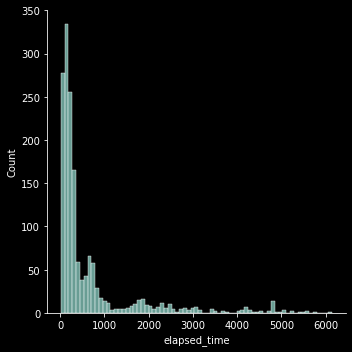

In [20]:
sns.displot(y_train)

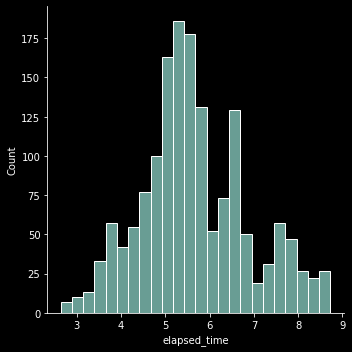

In [21]:
sns.displot(np.log(y_train))

In [22]:
y_train_log = np.log(y_train)

In [23]:
y_train_log

0       7.472501
1       7.472501
2       7.711997
3       6.165418
6       6.670766
          ...   
1946    3.688879
1947    4.499810
1948    4.948760
1949    5.420535
1950    4.007333
Name: elapsed_time, Length: 1586, dtype: float64

## Scaler ##

In [24]:
# min_max = MinMaxScaler()

In [25]:
# min_max.fit(X_train)

In [26]:
# X_train_scaled = min_max.transform(X_train)
# X_test_scaled = min_max.transform(X_test)

#### Algos

In [27]:
reg = LinearRegression()
reg.fit(X_train,y_train_log)
y_pred_reg_log = reg.predict(X_test)

In [28]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train,y_train_log)
y_pred_xgb_log = xgb_reg.predict(X_test)

In [29]:
forrest_reg = RandomForestRegressor()
forrest_reg.fit(X_train,y_train_log)
y_pred_forrest_log = forrest_reg.predict(X_test)

In [30]:
mae_reg = mean_absolute_error(y_test,np.exp(y_pred_reg_log))
mape_reg = mean_absolute_percentage_error(y_test, np.exp(y_pred_reg_log))
rmse_reg  = np.sqrt(mean_squared_error(y_test,np.exp(y_pred_reg_log)))
print(f'mae_reg : {mae_reg}')
print(f'mape_reg : {mape_reg}')
print(f'rmse_reg: {rmse_reg}')

mae_reg : 526.4248622178513
mape_reg : 0.8705886870503146
rmse_reg: 1969.897242295928


In [31]:
mae_xgb = mean_absolute_error(y_test,np.exp(y_pred_xgb_log))
mape_xgb = mean_absolute_percentage_error(y_test, np.exp(y_pred_xgb_log))
rmse_xgb  = np.sqrt(mean_squared_error(y_test,np.exp(y_pred_xgb_log)))
print(f'mae_xgb : {mae_xgb}')
print(f'mape_xgb: {mape_xgb}')
print(f'rmse_xgb: {rmse_xgb}')

mae_xgb : 107.94050645697607
mape_xgb: 0.19164154959118818
rmse_xgb: 318.1370011849518


In [32]:
mae_forrest = mean_absolute_error(y_test,np.exp(y_pred_forrest_log))
mape_forrest = mean_absolute_percentage_error(y_test, np.exp(y_pred_forrest_log))
rmse_forrest  = np.sqrt(mean_squared_error(y_test,np.exp(y_pred_forrest_log)))
print(f'mae_forrest : {mae_forrest}')
print(f'mape_forrest: {mape_forrest}')
print(f'rmse_forrest: {rmse_forrest}')

mae_forrest : 88.64618024373044
mape_forrest: 0.18120425088443473
rmse_forrest: 220.52577021656606


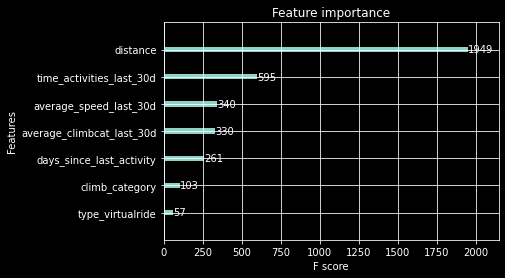

In [33]:
xgb.plot_importance(xgb_reg)
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

In [34]:
data = {
    'MAE':[mae_naive,mae_reg,mae_xgb,mae_forrest],
    'MAPE':[mape_naive,mape_reg,mape_xgb,mape_forrest],
    'RMSE':[rmse_naive,rmse_reg,rmse_xgb,rmse_forrest]
}

comparaison_df = pd.DataFrame(data, index=['naive','linreg','xgbreg','forrest'])
comparaison_df.sort_values(by=['MAPE'])

,MAE,MAPE,RMSE
forrest,88.646180,0.181204,220.525770
xgbreg,107.940506,0.191642,318.137001
naive,212.762185,0.352196,450.068258
linreg,526.424862,0.870589,1969.897242


### Explicabilty

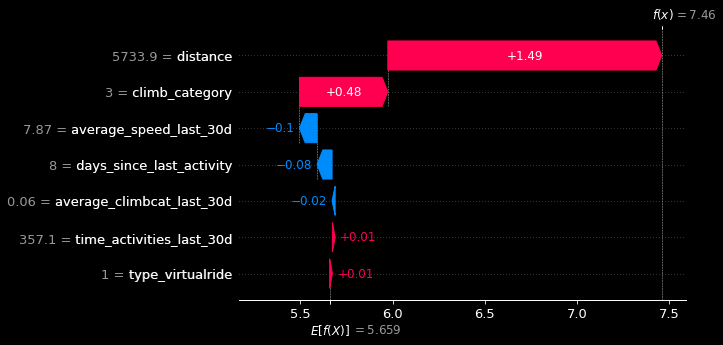

In [35]:
explainer = shap.Explainer(xgb_reg)
shap_values = explainer(X_train)
shap.plots.waterfall(shap_values[0])

### Prediction Alpe d'huez

In [36]:
query = {
    "query": {
        "match": {
            "_id": 2787335981548134218
        }
    }
}

result = database.search(
    index="index_route",
    size=1000,
    body= query
)

route_alpe = result['hits']['hits'][0]['_source']
segments_alpe = route_alpe.get("segmentation")
segments_alpe_df = pd.DataFrame(segments_alpe)
segments_alpe_df

,distance,altitude_gain,average_grade,all_points
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000..."
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45...."
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45..."
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000..."


**Time Activities last 30d and Avg Speed**

In [37]:
today = date.today()
end_date = today - timedelta(days=1)
start_date = end_date - timedelta(days=30)

In [38]:
activities_last_30d = activities_df[activities_df['start_date'].between(start_date,end_date)]
time_activities_last_30d = round((activities_last_30d['elapsed_time'].sum()/60),2)

result = activities_last_30d['average_speed'].mean()
if np.isnan(result):
    average_speed_last_30d = 0
else:
    average_speed_last_30d = result

In [39]:
segments_alpe_df['time_activities_last_30d'] = time_activities_last_30d
segments_alpe_df['average_speed_last_30d'] = average_speed_last_30d
segments_alpe_df

,distance,altitude_gain,average_grade,all_points,time_activities_last_30d,average_speed_last_30d
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000...",45.1,6.366
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45....",45.1,6.366
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45...",45.1,6.366
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000...",45.1,6.366


**Home Trainer**

In [40]:
segments_alpe_df['type_virtualride'] = 1
segments_alpe_df

,distance,altitude_gain,average_grade,all_points,time_activities_last_30d,average_speed_last_30d,type_virtualride
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000...",45.1,6.366,1
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45....",45.1,6.366,1
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45...",45.1,6.366,1
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000...",45.1,6.366,1


**Climb Category**

In [41]:
climb_category = []
for average_grade, distance in zip(segments_alpe_df['average_grade'],segments_alpe_df['distance']):
    result = average_grade * distance
    if result <= 8000:
        climb_cat = 0
    elif result > 8000 and result <= 16000:
        climb_cat = 1
    elif result > 16000 and result <= 32000:
        climb_cat = 2
    elif result > 32000 and result <= 64000:
        climb_cat = 3
    elif result > 64000 and result <= 80000:
        climb_cat = 4
    elif result > 80000:
        climb_cat = 5
    climb_category.append(climb_cat)
climb_category

[0, 0, 0, 5]

In [42]:
segments_alpe_df['climb_category'] = climb_category
segments_alpe_df

,distance,altitude_gain,average_grade,all_points,time_activities_last_30d,average_speed_last_30d,type_virtualride,climb_category
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000...",45.1,6.366,1,0
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45....",45.1,6.366,1,0
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45...",45.1,6.366,1,0
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000...",45.1,6.366,1,5


**Days since last_activities**

In [43]:
result = date.today() - activities_df.loc[0]['start_date']
segments_alpe_df['days_since_last_activity'] = result.days
segments_alpe_df

,distance,altitude_gain,average_grade,all_points,time_activities_last_30d,average_speed_last_30d,type_virtualride,climb_category,days_since_last_activity
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000...",45.1,6.366,1,0,31
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45....",45.1,6.366,1,0,31
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45...",45.1,6.366,1,0,31
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000...",45.1,6.366,1,5,31


**AVg climb Last30D**

In [44]:
segments_alpe_df['average_climbcat_last_30d'] = round(segments_df[segments_df['start_date'].between(start_date,end_date)]['climb_category'].mean(),2)

In [45]:
segments_alpe_df

,distance,altitude_gain,average_grade,all_points,time_activities_last_30d,average_speed_last_30d,type_virtualride,climb_category,days_since_last_activity,average_climbcat_last_30d
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000...",45.1,6.366,1,0,31,1.5
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45....",45.1,6.366,1,0,31,1.5
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45...",45.1,6.366,1,0,31,1.5
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000...",45.1,6.366,1,5,31,1.5


**Prediction**

In [46]:
cols_to_predict = ['distance','climb_category','type_virtualride','time_activities_last_30d','days_since_last_activity','average_climbcat_last_30d','average_speed_last_30d']
datas = segments_alpe_df[cols_to_predict]
datas

,distance,climb_category,type_virtualride,time_activities_last_30d,days_since_last_activity,average_climbcat_last_30d,average_speed_last_30d
0,270.55,0,1,45.1,31,1.5,6.366
1,422.22,0,1,45.1,31,1.5,6.366
2,427.89,0,1,45.1,31,1.5,6.366
3,12615.51,5,1,45.1,31,1.5,6.366


In [47]:
alpe_pred_reg = reg.predict(datas)
elapsed_time_reg = relativedelta(seconds=(np.exp(alpe_pred_reg)).sum())
elapsed_time_reg

relativedelta(hours=+2, minutes=+12, seconds=+25.87)

In [48]:
alpe_pred_xgb = xgb_reg.predict(datas)
elapsed_time_xgb = relativedelta(seconds=(np.exp(alpe_pred_xgb)).sum())
elapsed_time_xgb

relativedelta(hours=+1, minutes=+11, seconds=+53.6865)

In [49]:
alpe_pred_forrest = forrest_reg.predict(datas)
elapsed_time_forrest = relativedelta(seconds=(np.exp(alpe_pred_forrest)).sum())
elapsed_time_forrest

relativedelta(hours=+1, minutes=+22, seconds=+35.279)

In [50]:
elapsed_time_naive

relativedelta(minutes=+38, seconds=+27.8794)

In [51]:
def format_hms_relativedelta(relative_delta):
    hour = int(relative_delta.hours)
    minutes = int(relative_delta.minutes)
    seconds = int(relative_delta.seconds)
    print(f'Prediction {hour}h{minutes}m{seconds}sec')
    return f'{hour}h{minutes}m{seconds}sec'

In [52]:
def compute_kmh(time,distance):
    return (distance/time)*3.6

In [53]:
def compute_pred_seconds(pred):
    return round(np.exp(pred).sum(),2)

In [54]:
distance = segments_alpe_df['distance'].sum()
distance

13736.17

In [55]:
data = {
    'Prediction':[
                  format_hms_relativedelta(elapsed_time_naive),
                  format_hms_relativedelta(elapsed_time_reg),
                  format_hms_relativedelta(elapsed_time_xgb),
                  format_hms_relativedelta(elapsed_time_forrest),
                  '0h31m39s'
                 ],
    'Mean_speed(km/h)':[
                        distance / elapsed_time_pred_naive_sec * 3.6,
                        compute_kmh(compute_pred_seconds(alpe_pred_reg),distance),
                        compute_kmh(compute_pred_seconds(alpe_pred_xgb),distance),
                        compute_kmh(compute_pred_seconds(alpe_pred_forrest),distance),
                        distance / 1899 * 3.6
                        ]
}

comparaison_pred_df = pd.DataFrame(data, index=['naive','linreg','xgbreg','forrest','strava'])
comparaison_pred_df

Prediction 0h38m27sec
Prediction 2h12m25sec
Prediction 1h11m53sec
Prediction 1h22m35sec


,Prediction,Mean_speed(km/h)
naive,0h38m27sec,21.426688
linreg,2h12m25sec,6.223385
xgbreg,1h11m53sec,11.463553
forrest,1h22m35sec,9.979297
strava,0h31m39s,26.040133
